## Keyword and N-Gram for full stream

Finding keywords from the tweets in a couple of different ways. 

First, get plain keywords with CountVectorizer from sklearn

Then, use CountVectorizier to get 2-grams and 3-grams, then use only the words in those as keywords. 

Use spacy as preprocessor to only get words with certain tags. 

### Load

In [20]:
import os
from dotenv import load_dotenv
import pandas as pd
from twarc import Twarc2, expansions
from tweet_processing import StreamTweetProcessor

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
import seaborn as sns

In [21]:
load_dotenv()

data_dir="data" 
twarc_client = Twarc2(
    consumer_key=os.environ["consumer_key"], 
    consumer_secret=os.environ["consumer_secret"],
    access_token=os.environ["access_token"], 
    access_token_secret=os.environ["access_token_secret"]
)

tp = StreamTweetProcessor(twarc_client=twarc_client, data_dir=data_dir)

groups = ["longevity-pranab"]#, "CA-Abundance-Economy"]
following, tweets, refs  = [], [], []
dfs = [following, tweets, refs]

for g in groups: 
    [f, t, r] = tp.load_stream_seed_data(g)
    refs.append(r), tweets.append(t) , following.append(f)

dfs = [pd.concat(df) for df in dfs]
df_following, df_tweets, df_refs = dfs

### Peek

In [22]:
df_tweets = df_tweets[['entities.mentions.usernames', 'id', 'text', 'author_id', 'author.username', 'created_at', 'public_metrics.like_count', 'public_metrics.quote_count', 'public_metrics.reply_count', 'public_metrics.retweet_count','attachments.media','attachments.media_keys']]

df_tweets['created_at'] = pd.to_datetime(df_tweets['created_at'])

# ensure consistency in id/name
assert df_tweets.author_id.value_counts().to_list() ==  df_tweets["author.username"].value_counts().to_list()
# df_tweets.dropna().head()

/tmp/ipykernel_74634/829020691.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets['created_at'] = pd.to_datetime(df_tweets['created_at'])


In [23]:
# Counting "pure" tweets
# TODO: include retweets, urls
# TODO: use df_tweets.entities.mentions.usernames to exemot from preprocessing

n = df_tweets['attachments.media'].isna().sum()/df_tweets.shape[0]
print(f"Percentage of tweets without media: {n:.2%}")

df_no_mentions_no_media = df_tweets[(df_tweets['attachments.media'].isna()) & (df_tweets['entities.mentions.usernames'].isna())]

Percentage of tweets without media: 90.32%


In [24]:
import re

def preprocess(text):
    text = text.lower()
    # replace first \n with space
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\\n', ' ', text)
    
    text = re.sub(r'\S*@\S*\s?',' ', text) # remove email addresses
    
    # remove unicode characters, except @ and #
    # text = re.sub(r'[^\x00-\x7f]',r' ', text)

    return text

from nltk.corpus import stopwords
from string import punctuation

stop=set(stopwords.words('english'))


In [25]:
print(df_no_mentions_no_media["text"].tolist()[10])

preprocess(df_no_mentions_no_media["text"].tolist()[10])

For clustering publications to map a new field, are there any better algs than Word2Vec + LDA (ala https://t.co/93SkaAgpjW)?


'for clustering publications to map a new field, are there any better algs than word2vec + lda (ala '

In [26]:
n = 6
print(df_no_mentions_no_media["text"].tolist()[n])

preprocess(df_no_mentions_no_media["text"].tolist()[n])

Does anyone know what the stats are on % of graduate students that go on to receive a tenured professorship vs % of 'successful' startups (incorporated -&gt; return 2-3x+) across different industries?


"does anyone know what the stats are on % of graduate students that go on to receive a tenured professorship vs % of 'successful' startups (incorporated -&gt; return 2-3x+) across different industries?"

In [27]:
n = 5
print(df_no_mentions_no_media["text"].tolist()[n])

preprocess(df_no_mentions_no_media["text"].tolist()[n])

I recently read and enjoyed ‘Less’, ‘Overstory’, and ‘The Idiot’ - before that, I hadn’t read many Pulitzer Prize or finalist books. Any suggestions for other books in that category?


'i recently read and enjoyed ‘less’, ‘overstory’, and ‘the idiot’ - before that, i hadn’t read many pulitzer prize or finalist books. any suggestions for other books in that category?'

### Preprocess Tweets

In [28]:
## This is a list of words that are in all the tweets with no media 
preprocessed_tweets = [preprocess(i) for i in df_no_mentions_no_media["text"].tolist()]

corpus = " ".join(preprocessed_tweets).split() # single string containing all tweets for counting and such

In [29]:
## This is a list of words that are in all the tweets with no media 
preprocessed_tweets = [preprocess(i) for i in df_no_mentions_no_media["text"].tolist()]

corpus = " ".join(preprocessed_tweets).split() # single string containing all tweets for counting and such

<AxesSubplot:>

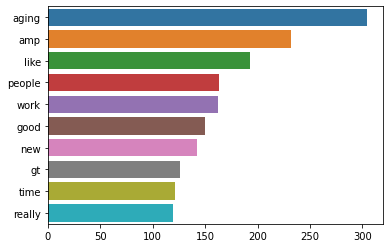

In [30]:
def get_ngram_counts(corpus, n=None):
    """
    Get the Ngrams from a corpous
    n=1 to get the count of plain old words
    using sklearn built in stop words, which they are clear isn't a universal solution
    """
    vec = CountVectorizer(ngram_range=(n, n), stop_words="english").fit(corpus)
    bag_of_words = vec.transform(corpus) # create bag of words rep of corpus
    sum_words = bag_of_words.sum(axis=0) # sum the columns to get total number of occurences for that ngram
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()] # match sum to to ngram
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) # sort for return 
    return words_freq

words_freq = get_ngram_counts([i for i in corpus if i not in stop], n=1)
x, y= [], []

for word,count in words_freq[:10]:
    # if (word not in stop):
    x.append(word)
    y.append(count)
        
sns.barplot(x=y,y=x)

## 2grams

Step One:
* get the 2grams

Step two: 
* get the most common words from only the two-grams

This seems to be the best way to get get keywords from tweets

<AxesSubplot:>

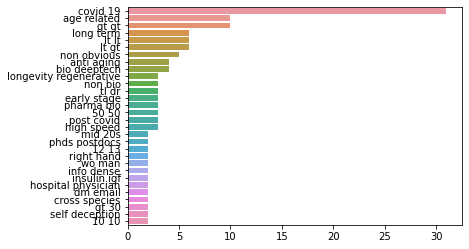

In [31]:
bigrams = get_ngram_counts(
    corpus, 
    2
)

top_n_bigrams = bigrams[:30]

x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x)


In [32]:
preprocessed_tweets[0]

"i'd like to have fluency with basic game theory well enough to have intuition for the situations presented in parfit's 'reasons and persons'. any suggestions for a text or tutor?  want to build really strong, simple intuitions to go with the relevant equations - nothing fancy."

In [33]:
for num, text in enumerate(preprocessed_tweets):
    if "13" in text:
        print(num)
        print(text)
        break

67
hosting happy hour in sf, monday 12/13 - for grad students / postdocs / industry scientists interested in joining longevity/regenerative medicine cos - will describe a project we're working on + other good cos that are hiring - fill out to come -&gt; 


In [34]:
def get_ngram_keyword_counts(corpus, ngram_counts):
    """
    VERY IMPORTANT: Only pass the number of ngram_counts that are of interest
        e.g. only use the top 20 ngrams to make this vocba smaller. Don't pass alllll the ngrams
    Take a set of n_gram counts, and then filter out the corpus to contain only the words used in those ngrams
    Get the keywords of that corpus
    """
    words_from_ngrams = set()
    for gram, count in ngram_counts:
        for word in gram.split():
            words_from_ngrams.add(word)
    
    ngram_corpus = [i for i in corpus if i in words_from_ngrams]
    return get_ngram_counts(ngram_corpus, 1)

<AxesSubplot:>

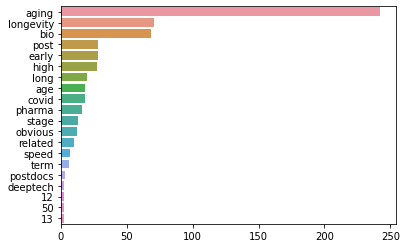

In [35]:
n = 2

ngram_counts = get_ngram_counts(corpus, n)
ngram_keyword_counts = get_ngram_keyword_counts(corpus, ngram_counts[:20]) ## get keywords from top 20 ngrams


x, y= [], []
for word,count in ngram_keyword_counts[:20]:
    x.append(word)
    y.append(count)
       
        
sns.barplot(x=y,y=x)

In [36]:


words_from_bigrams = []

for two_gram, count in top_n_bigrams:
    for word in two_gram.split():
        words_from_bigrams.append(word)
    
bigram_word_corpus = [i for i in corpus if i in words_from_bigrams]

most = get_word_count([i for i in corpus if i in words_from_bigrams])

x, y= [], []
for word,count in most[:20]:
    # if (word not in stop):
    x.append(word)
    y.append(count)
       
        
sns.barplot(x=y,y=x)

NameError: name 'get_word_count' is not defined

## Notes on 2-grams
* interesting that there are many 2-grams that have the word "aging", but aging isn't in the top of th 1-grams 

* probably worth it to get the keywords of the 2,3, and 4 grams (likly a better signal than the plain old keywords) 

* 

### 3Grams

Same steps as the twograms above

In [ ]:
trigrams=get_ngram_counts([preprocess(i) for i in df_no_mentions_no_media["text"].tolist()],3)
top_n_trigrams = trigrams[:20]
x,y=map(list,zip(*top_n_trigrams)) 
sns.barplot(x=y,y=x)

In [ ]:
words_from_trigrams = []

for gram, count in trigrams[:100]:
    for word in gram.split():
        words_from_trigrams.append(word)
    
trigram_word_corpus = [i for i in corpus if i in words_from_trigrams]

most = get_word_count(trigram_word_corpus)

x, y= [], []
for word,count in most[:20]:
    # if (word not in stop):
    x.append(word)
    y.append(count)
       
        
sns.barplot(x=y,y=x)


## Spacy Hotwords
https://betterprogramming.pub/extract-keywords-using-spacy-in-python-4a8415478fbf

* 

In [ ]:
from collections import Counter
from string import punctuation
import spacy 

def get_hotwords(text):
    result = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN'] # 1
    doc = nlp(text.lower()) # 2
    for token in doc:
        # 3
        if(token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        # 4
        if(token.pos_ in pos_tag):
            result.append(token.text)
    return result # 5

nlp = spacy.load("en_core_web_sm")



In [ ]:
hotwords = get_hotwords(" ".join(preprocessed_tweets))
hotwords = set(hotwords)

In [ ]:
most = get_word_count([i for i in corpus if i in hotwords])

x, y= [], []
for word,count in most[:30]:
    # if (word not in stop):
    x.append(word)
    y.append(count)
       
        
sns.barplot(x=y,y=x)